In [19]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import datetime
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy
from sklearn.decomposition import PCA


def generateNormalizationPlot(peak_areas,runOrder,batches,met_names,qc_inds,samp_inds,path):

    for x in range(peak_areas.shape[1]):
        fig,axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,1))
        axes[0].set_title("QC samples")
        axes[1].set_title("research samples")
        axes[0].scatter(runOrder[qc_inds],peak_areas[qc_inds,x],c=batches[qc_inds],s=1)
        axes[0].set_yticks([],[])
        #axes[0,0].set_ylabel(met_names[x],fontsize=6)
        
        axes[1].scatter(runOrder[samp_inds],peak_areas[samp_inds,x],c=batches[samp_inds],s=1)
        axes[1].set_yticks([],[])
        plt.tight_layout()
        plt.savefig(path + met_names[x] + ".png")
        plt.close()
        
def half_min_imputation(arr):

    #find the minimum non-zero value of each compound
    max_vals = [np.min([x for x in c if x > 1e-3]) for c in arr.transpose()]

    #impute values 
    data_imp = np.zeros(arr.shape)
    numImputted = 0
    numNon = 0

    for c in range(arr.shape[1]):
      for r in range(arr.shape[0]):
        #if not a missing value
        if arr[r,c] > 1e-3:
          data_imp[r,c] = arr[r,c]
          numNon += 1
        #if it is a missing value
        else:
          data_imp[r,c] = max_vals[c]/2
          numImputted += 1
    print(numImputted/(numImputted + numNon),"of values imputted")
    return data_imp

def normalizeData(peak_areas,batchInfo,qc_inds):
    reg = RandomForestRegressor(n_jobs=10)
    X = np.array(batchInfo[qc_inds])
    y = peak_areas[qc_inds] - np.mean(peak_areas[qc_inds],axis=0)
    reg.fit(X,y)
    preds = reg.predict(batchInfo)
    return peak_areas - preds

In [21]:
ship1Dir = "Y:/LLFS/data_analysis/polars/shipment1_analysis/integration/positive/"
ship2Dir = "Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/"
experimentParametersFn = "Y:/LLFS/data_analysis/sample_metadata/LLFS_Experiment_parameters_Shipment1and2.csv"
numQC = 9

In [6]:
metadata = pd.read_csv(experimentParametersFn)
metadata

,Batch #,Batch,Metabolomics identifier,Shipment
0,1,V,10014843_1,1
1,1,V,10014843_2,1
2,6,Q,10016673_1,1
3,6,Q,10016673_2,1
4,2,U,10041309_1,1
...,...,...,...,...
4000,43,AQ,49975486_1,2
4001,43,AQ,49975486_2,2
4002,12,F,49989098_1,1
4003,12,F,49989098_2,1


In [7]:
batches = [x for x in list(set(metadata["Batch"].values)) if x != "AR"]
batches.sort()
batches

['A',
 'AA',
 'AB',
 'AC',
 'AD',
 'AE',
 'AF',
 'AG',
 'AH',
 'AI',
 'AJ',
 'AK',
 'AL',
 'AM',
 'AN',
 'AO',
 'AP',
 'AQ',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [12]:
metadata = metadata[metadata["Batch"].isin(batches)]
metadata

,Batch #,Batch,Metabolomics identifier,Shipment
0,1,V,10014843_1,1
1,1,V,10014843_2,1
2,6,Q,10016673_1,1
3,6,Q,10016673_2,1
4,2,U,10041309_1,1
...,...,...,...,...
4000,43,AQ,49975486_1,2
4001,43,AQ,49975486_2,2
4002,12,F,49989098_1,1
4003,12,F,49989098_2,1


In [14]:
qc_df = {}
for batch in batches:
    batchNum = metadata[metadata["Batch"] == batch]["Batch #"].values[0]
    tmpNumQC = numQC
    if batch == "AP":
        tmpNumQC = 9
    if batch == "AR":
        tmpNumQC = 2
    #elif batch == "V":
    #    tmpNumQC = 8
    #else:
    #    tmpNumQC = numQC
    for qc in range(1,tmpNumQC+1):
        if qc < 10:
            if batch not in  ["A","B","C","D","F"]:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_Splash_0" + str(qc)}
            else:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_0" + str(qc)}
        else:
            if batch not in  ["A","B","C","D","F"]:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_Splash_" + str(qc)}
            else:
                qc_df[len(qc_df)] = {"Batch":batch,"Batch #":batchNum,"Metabolomics identifier":"QC_" + str(qc)}
qc_df = pd.DataFrame.from_dict(qc_df,orient="index")
metadata = pd.concat((metadata,qc_df),axis=0,ignore_index=True)
metadata

,Batch #,Batch,Metabolomics identifier,Shipment
0,1,V,10014843_1,1.0
1,1,V,10014843_2,1.0
2,6,Q,10016673_1,1.0
3,6,Q,10016673_2,1.0
4,2,U,10041309_1,1.0
...,...,...,...,...
4319,26,Z,QC_Splash_05,NaN
4320,26,Z,QC_Splash_06,NaN
4321,26,Z,QC_Splash_07,NaN
4322,26,Z,QC_Splash_08,NaN


In [23]:
batchMapper = {batch:"" for batch in batches}
for batch in batches:
    for datadir in [ship1Dir,ship2Dir]:
        folders = os.listdir(datadir)
        for fold in folders:
            if "Batch" + batch in fold[-1*len("Batch" + batch):] or "Batch" + batch + "_" in fold and "2ndPlate" not in fold or "Batch" + batch + "-" in fold :
                batchMapper[batch] = datadir + fold

In [25]:
batchMapper

{'A': 'Y:/LLFS/data_analysis/polars/shipment1_analysis/integration/positive/BatchA',
 'AA': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20220928_LLFS_pP_BatchAA',
 'AB': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20220930_LLFS_pP_BatchAB',
 'AC': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20221003_LLFS_pP_BatchAC',
 'AD': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20221005_LLFS_pP_BatchAD',
 'AE': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20221009_LLFS_pP_BatchAE',
 'AF': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20221011_LLFS_pP_BatchAF',
 'AG': 'Y:/LLFS/data_analysis/polars/shipment2_analysis/integration/positive_knowns/skyline_documents/20221013_LLFS_pP_BatchAG',
 'AH': 'Y:/L

In [27]:
mergedDf = pd.DataFrame()
goodInds = []
filenames = ["" for _ in range(len(metadata))]
times = [datetime.datetime(1,1,1,1,1) for _ in filenames]
accounted = [False for _ in filenames]
for batch in batches:
        filt = metadata[metadata["Batch"] == batch]
        try: peak_areas = pd.read_csv(batchMapper[batch] + "/peak_areas_profile.csv",index_col=0)
        except: peak_areas = pd.read_csv(batchMapper[batch] + "/peak_areas.csv",index_col=0)
        
        if len(mergedDf) > 0:
            goodInds = list(set(peak_areas.index.values).intersection(set(mergedDf.index.values)))
            peak_areas = peak_areas.loc[goodInds,:]
            mergedDf = mergedDf.loc[goodInds,:]
        
        metInfo = peak_areas[peak_areas.columns.values[:3]]
        peak_areas = peak_areas[peak_areas.columns.values[3:]]
        file_times = pd.read_csv(batchMapper[batch] + "/aq_time_report.csv",index_col=0)
        for index,row in file_times.iterrows():
            tmp = row["Acquired Time"]
            month = int(tmp.split()[0].split("/")[0])
            day = int(tmp.split()[0].split("/")[1])
            year = int(tmp.split()[0].split("/")[2])
            hour = int(tmp.split()[1].split(":")[0])
            minute = int(tmp.split()[1].split(":")[1])
            if "PM" in tmp and hour != 12:
                hour += 12
            elif "AM" in tmp and hour == 12:
                hour -= 12
            file_times.at[index,"Acquired Time"] = datetime.datetime(year,month,day,hour,minute)
        files = [x.replace(" Area","") for x in peak_areas.columns.values]
        for index,row in filt.iterrows():
            matches = [x for x in files if row["Metabolomics identifier"] in x and "terative" not in x]
            if len(matches) > 0:
                matches.sort(key = lambda x: file_times.at[x+".d","Acquired Time"],reverse=True)
                t = file_times.at[matches[0] + ".d","Acquired Time"]
                #print([file_times.at[x + ".d","Acquired Time"] for x in matches])
                if t > times[index]:
                    times[index] = t
                    filenames[index] = matches[0]
                    accounted[index] = True

        mergedDf = pd.concat((mergedDf,peak_areas),axis=1,ignore_index=False)

times = [x.isoformat() for x in times]
metadata["filename polar pos"] = filenames
metadata["Acq times for polar pos"] = times
metadata["found matching filename polar pos"] = accounted
metadata["peak area sample name"] = ["Batch" + str(batch) + "_" + id for batch,id in zip(metadata["Batch #"],metadata["Metabolomics identifier"])]

In [28]:
filenames = list(metadata["filename polar pos"].values)
print(len(filenames))
goodCols = [f + " Area" for f in filenames if "Blank" not in f and f != ""]
filenames = [x.replace(" Area","") for x in goodCols]
print(len(filenames))
mergedDf = mergedDf[goodCols]
mergedDf = mergedDf.rename(mapper={c:c.replace(" Area","") for c in mergedDf.columns.values},axis=1)
mapper2 = {old:new for old,new in zip(metadata["filename polar pos"], metadata["peak area sample name"])}
mergedDf = mergedDf.rename(mapper=mapper2,axis=1)
filenames = [mapper2[x] for x in filenames]
metInfo.to_csv("metabolite_info_polar_pos.csv")
mergedDf.to_csv("merged_peak_areas_polar_pos.csv")
metadata["Acq times for polar pos"] = [datetime.datetime.fromisoformat(x) for x in metadata["Acq times for polar pos"].values]
metadata = metadata.sort_values(by = "Acq times for polar pos",ascending=True)
batchInfoDf = metadata.loc[metadata.index.values,["Acq times for polar pos","peak area sample name","Batch #"]]
batchInfoDf = batchInfoDf.rename(mapper={"Batch #":"batch"},axis=1)
batchInfoDf = batchInfoDf.set_index("peak area sample name")
batchInfoDf["order"] = list(range(1,len(batchInfoDf)+1))
batchInfoDf["sample batch order"] = list(range(1,len(batchInfoDf)+1))
batchInfoDf = batchInfoDf.loc[filenames,:]

for batch in list(set(batchInfoDf["batch"])):
    filt = batchInfoDf[batchInfoDf["batch"] == batch]
    filt = filt.sort_values(by="order",ascending=True)
    for index,i in zip(filt.index.values,range(1,len(filt)+1)):
        batchInfoDf.at[index,"sample batch order"] = i

batchInfoDf = batchInfoDf[["Acq times for polar pos","batch","sample batch order"]]
batchInfoDf = batchInfoDf.rename(mapper={"sample batch order":"order"},axis=1)        
batchInfoDf.to_csv("batchInfo_polar_pos.csv")

4324
4324


In [36]:
metadata.to_csv("metadata_outut_polar_pos.csv",index=False)

In [31]:
metadata[metadata["found matching filename polar pos"] == False].to_csv("missing.csv")

In [33]:
metadata[metadata["found matching filename polar pos"] == False]

,Batch #,Batch,Metabolomics identifier,Shipment,filename polar pos,Acq times for polar pos,found matching filename polar pos,peak area sample name


In [49]:
mergedDf

,Batch1_10014843_1,Batch1_10014843_2,Batch6_10016673_1,Batch6_10016673_2,Batch2_10041309_1,Batch2_10041309_2,Batch5_10094670_1,Batch5_10111300_1,Batch5_10187532_1,Batch1_10189066_1,...,Batch25_QC_Splash_09,Batch26_QC_Splash_01,Batch26_QC_Splash_02,Batch26_QC_Splash_03,Batch26_QC_Splash_04,Batch26_QC_Splash_05,Batch26_QC_Splash_06,Batch26_QC_Splash_07,Batch26_QC_Splash_08,Batch26_QC_Splash_09
Molecule Name,,,,,,,,,,,,,,,,,,,,,
DL-2-Aminooctanoic acid,3284194,2955848,5350205,4794754,4952298,7357391,3288702,5772590,4957835,3327745,...,441179,583477,576290,577851,577686,589980,585461,534244,563212,553937
Homostachydrine,899509,520530,3757569,1922866,1491728,1683421,2112875,1810983,3621754,610897,...,264317,334504,312343,322380,335403,312556,328793,285519,302364,301488
2-Aminobutyric acid,4723077,3976421,6765794,7817400,6925483,5362630,9132375,10544984,7324283,5853530,...,2300424,2572335,719878,1064342,726121,1420213,688584,775240,881959,1340654
Prolylleucine,3907778,3539806,5241923,6623070,2661574,2962626,4052654,5672427,3337051,2926995,...,1006947,1323339,1242318,1211858,1240372,1168954,1199499,1138339,1095312,1150829
Norvaline,51207828,32999616,90468616,76311664,81681336,67896720,42143344,65021744,63895216,28203372,...,8543074,14442137,13328594,13925746,14109791,15032593,15247206,14886188,15080281,15822142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LEUCINE,59962104,61042560,66696404,76577968,50222960,50539716,55739152,53308604,55414384,43975620,...,22871304,26721954,25485990,25463196,26078432,24691880,25100532,24064264,24192888,23692960
THEOPHYLLINE,12169354,4988397,5958349,9841839,2124821,1353448,5463901,5590360,3751970,2773478,...,147890,164539,163020,161193,154779,148625,149317,145746,144556,140934
U13C-U15N-Alanine,234266,185999,92478,121108,139673,131805,137925,147814,96460,178600,...,844076,891378,815222,832425,818647,776348,822705,758691,753338,755824


In [50]:
batchInfoDf

,Acq times for polar pos,batch,order
peak area sample name,,,
Batch1_10014843_1,2021-06-21 19:26:00,1,18
Batch1_10014843_2,2021-06-21 22:08:00,1,25
Batch6_10016673_1,2021-05-28 03:56:00,6,99
Batch6_10016673_2,2021-05-27 14:52:00,6,65
Batch2_10041309_1,2021-06-18 22:31:00,2,89
...,...,...,...
Batch26_QC_Splash_05,2022-09-23 07:05:00,26,53
Batch26_QC_Splash_06,2022-09-23 11:59:00,26,66
Batch26_QC_Splash_07,2022-09-23 16:52:00,26,79


In [51]:
metadata

,Batch #,Batch,Metabolomics identifier,Shipment,filename polar pos,Acq times for polar pos,found matching filename polar pos,peak area sample name
3937,11,A,QC_01,NaN,BatchA_pP_QC_01,2021-04-14 14:58:00,True,Batch11_QC_01
1672,11,A,27754655_1,1.0,BatchA_pP_27754655_1,2021-04-14 15:22:00,True,Batch11_27754655_1
1949,11,A,29898244_1,1.0,BatchA_pP_29898244_1,2021-04-14 15:45:00,True,Batch11_29898244_1
860,11,A,21170212_1,1.0,BatchA_pP_21170212_1,2021-04-14 16:08:00,True,Batch11_21170212_1
1052,11,A,22647044_1,1.0,BatchA_pP_22647044_1,2021-04-14 16:31:00,True,Batch11_22647044_1
...,...,...,...,...,...,...,...,...
197,23,W,12150199_1,2.0,BatchW_pP_12150199_1,2022-12-03 22:53:00,True,Batch23_12150199_1
590,23,W,17564502_1,2.0,BatchW_pP_17564502_1,2022-12-03 23:15:00,True,Batch23_17564502_1
154,23,W,11672128_2,2.0,BatchW_pP_11672128_2,2022-12-03 23:38:00,True,Batch23_11672128_2
194,23,W,12100624_2,2.0,BatchW_pP_12100624_2,2022-12-04 00:00:00,True,Batch23_12100624_2


In [52]:
peak_areas_imputted = deepcopy(mergedDf)
peak_areas_imputted[peak_areas_imputted.columns] = half_min_imputation(peak_areas_imputted.values.transpose()).transpose()

0.0 of values imputted


In [53]:
batchInfoDf = batchInfoDf.sort_values(by=["batch","order"],ascending=True)
runOrder = np.array(list(range(len(batchInfoDf))))
qc_inds = [x for x in range(len(batchInfoDf)) if "QC" in batchInfoDf.index.values[x]]
samp_inds = [x for x in range(len(batchInfoDf)) if x not in qc_inds]
batch_info = batchInfoDf[["batch","order"]].to_numpy()

In [54]:
#ensure order of peak areas and batch info is the same
peak_areas = peak_areas_imputted[batchInfoDf.index.values]
peak_areas_mat = np.log2(peak_areas.to_numpy()).transpose()

Text(0.5, 1.0, 'Before Normalization')

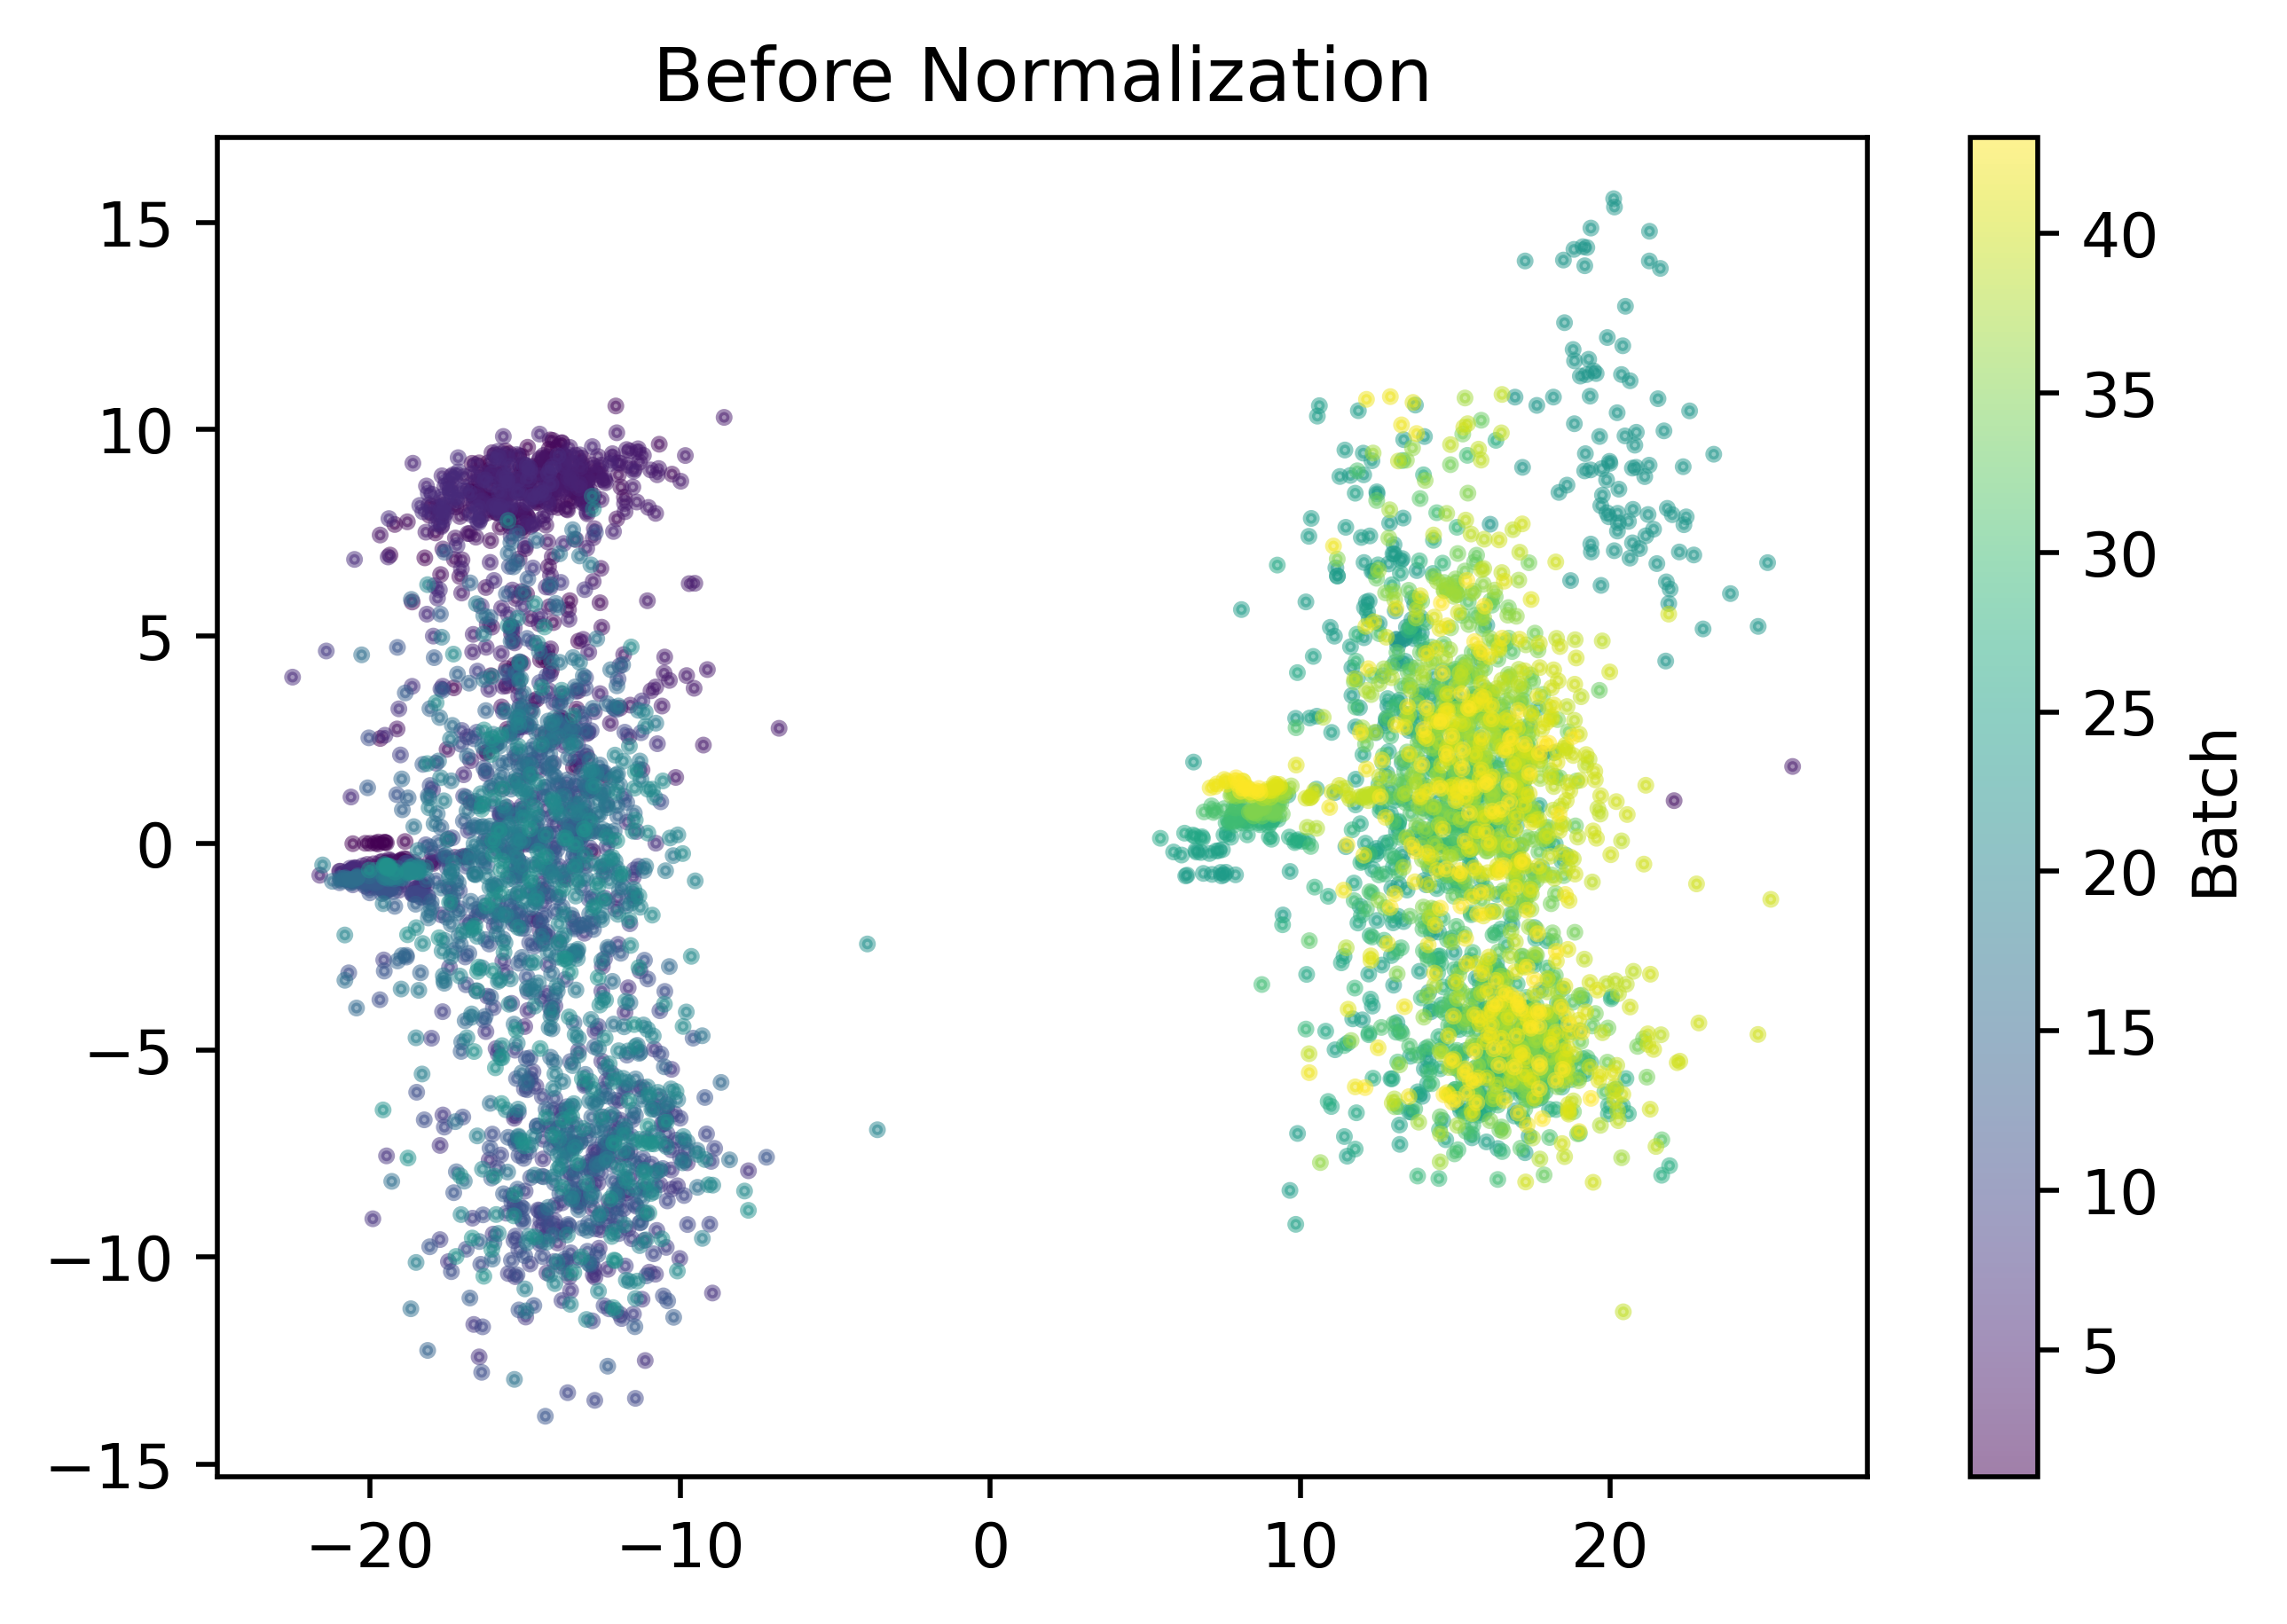

In [55]:
#do pca again
pca = PCA(n_components=2)
pca.fit(peak_areas_mat)
loads = pca.transform(peak_areas_mat)

#plot unnormalized PCA
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=batch_info[:,0],s=3,alpha=.5)
plt.colorbar(label="Batch")
plt.title("Before Normalization")

In [56]:
os.mkdir("unnormalized_peak_area_plots_polar_pos")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'unnormalized_peak_area_plots_polar_pos'

In [57]:
generateNormalizationPlot(peak_areas_mat,runOrder,batch_info[:,0],peak_areas.index.values,qc_inds,samp_inds,"unnormalized_peak_area_plots_polar_pos/")

In [58]:
peak_areas_norm = normalizeData(peak_areas_mat,batch_info,qc_inds)

Text(0.5, 1.0, 'After Normalization')

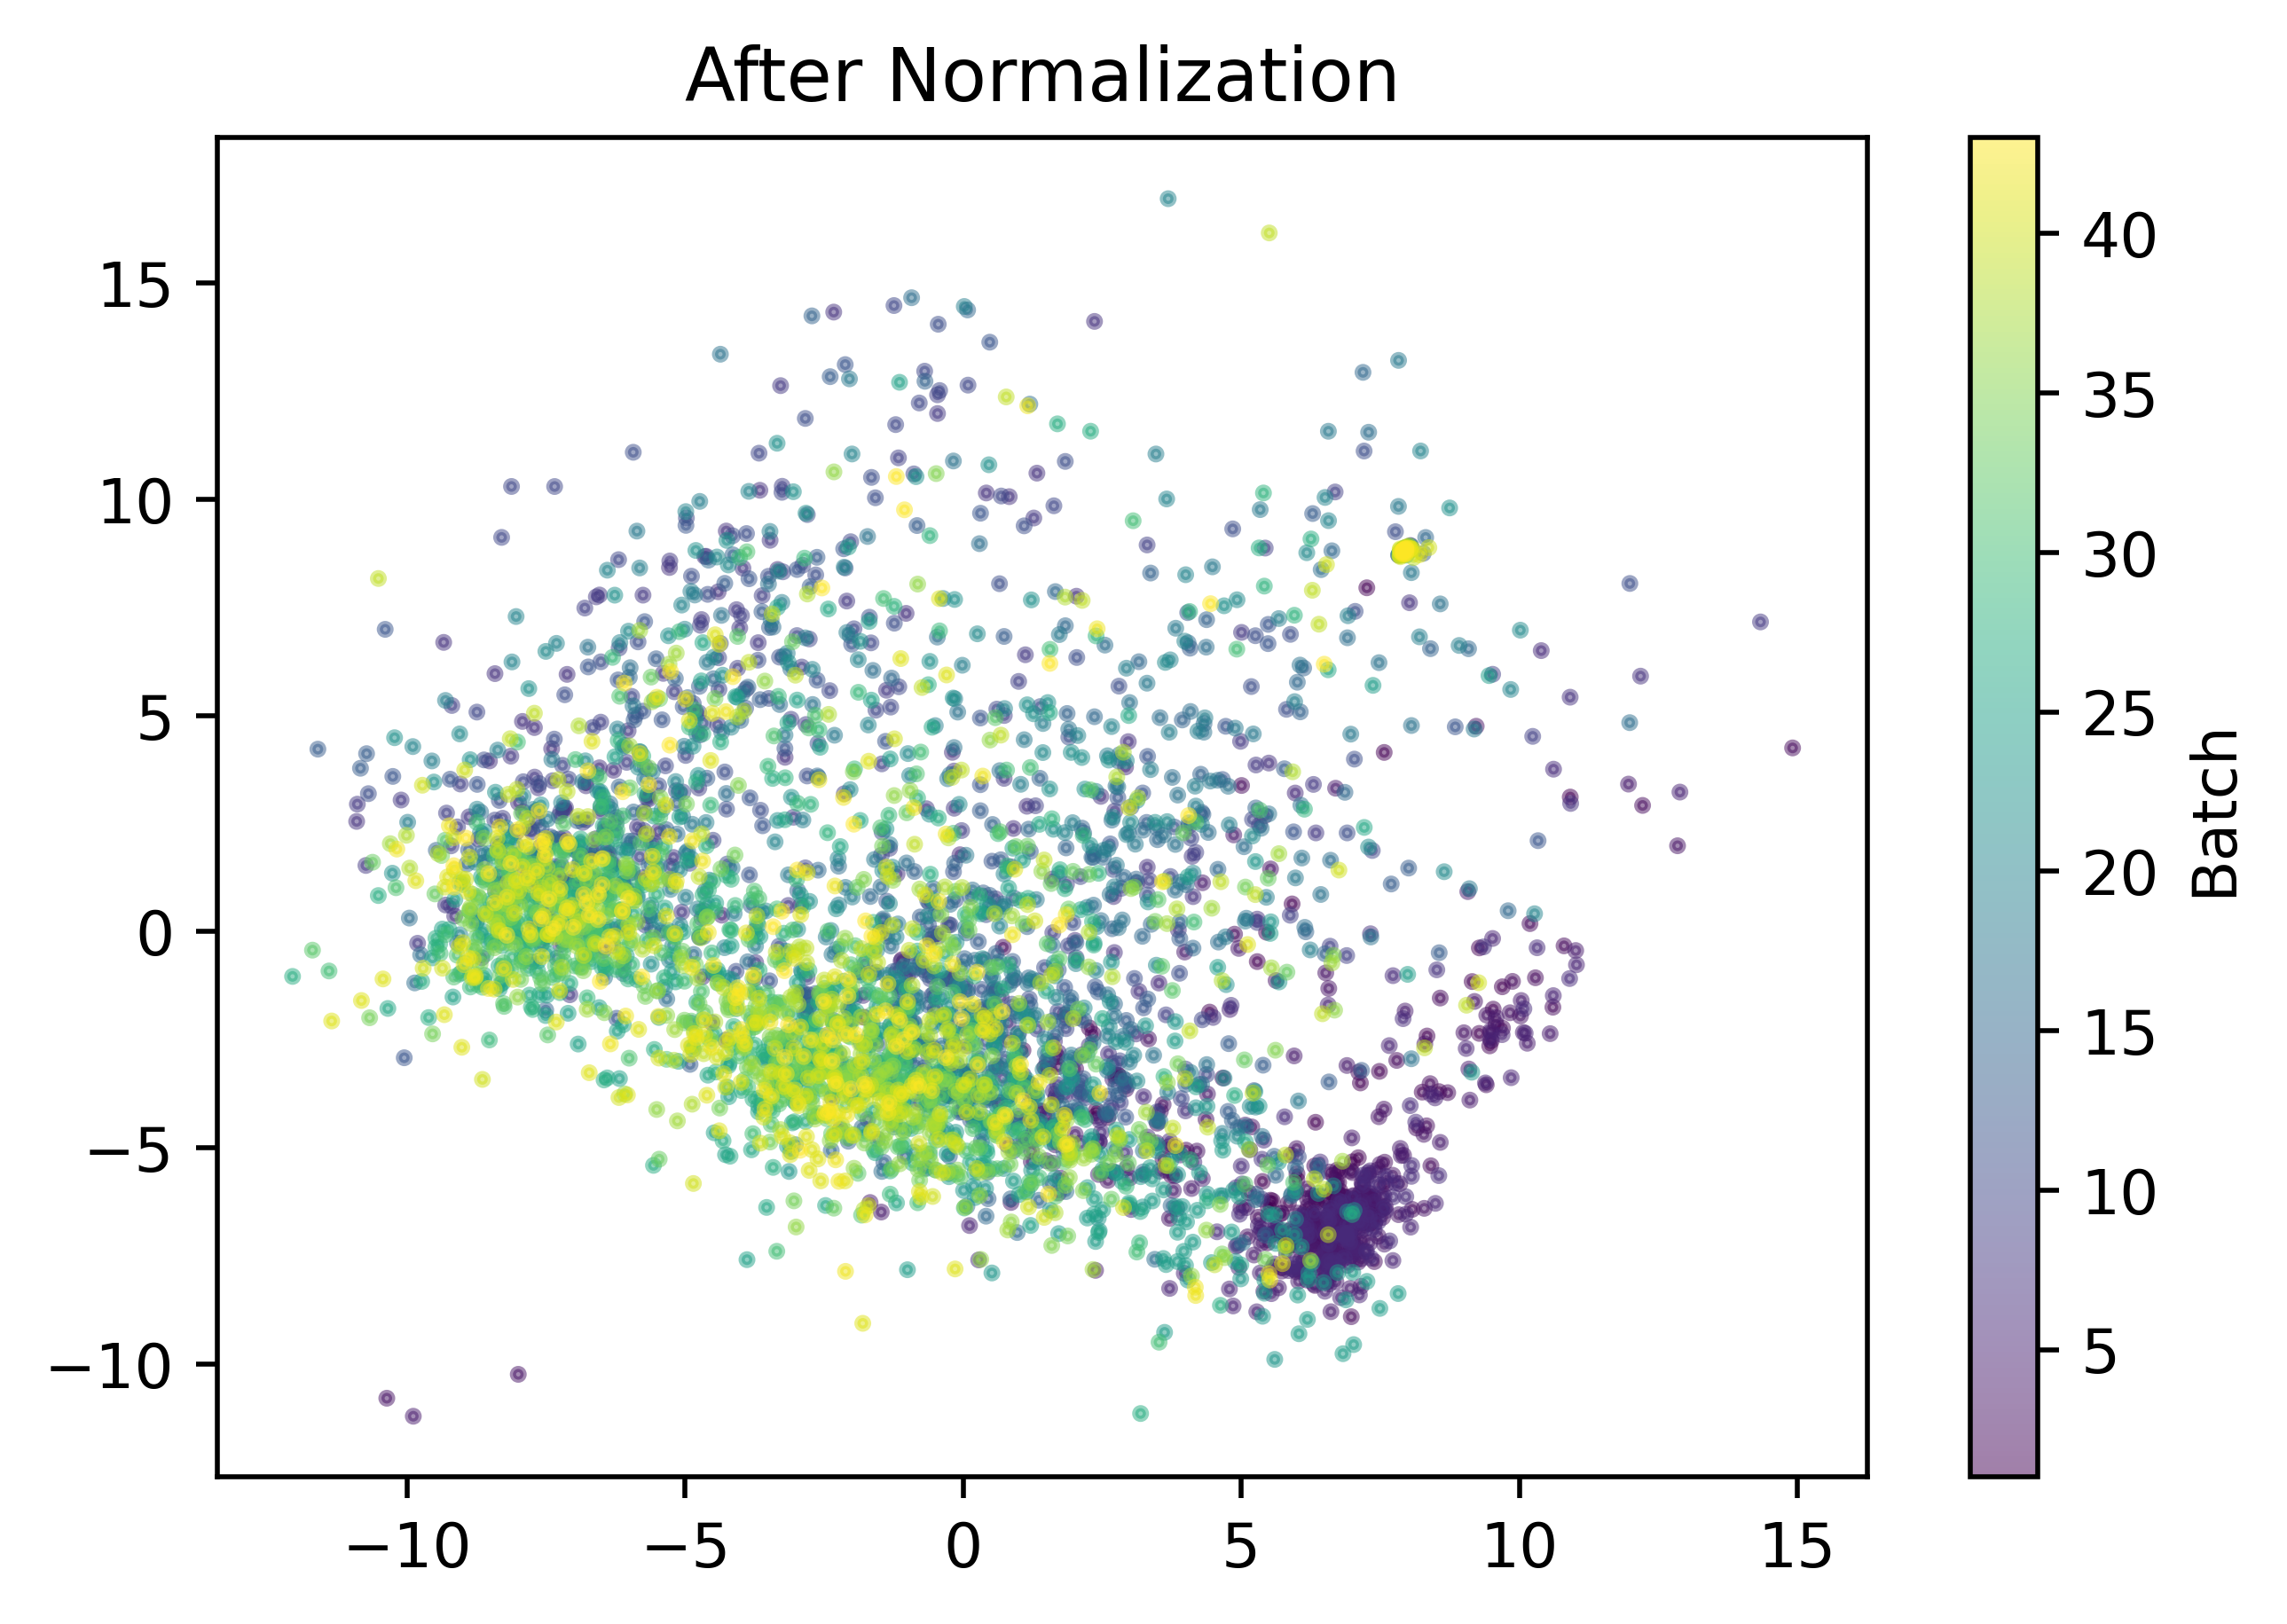

In [59]:
#do pca again
pca = PCA(n_components=2)
pca.fit(peak_areas_norm)
loads = pca.transform(peak_areas_norm)

#plot normalized PCA
plt.figure()
plt.scatter(loads[:,0],loads[:,1],c=batch_info[:,0],s=3,alpha=.5)
plt.colorbar(label="Batch")
plt.title("After Normalization")

In [60]:
peak_areas_norm = pd.DataFrame(np.power(2,peak_areas_norm).transpose(),index=peak_areas_imputted.index.values,columns=batchInfoDf.index.values)
peak_areas_norm

,Batch1_QC_Splash_01,Batch1_18270389_2,Batch1_13135943_1,Batch1_10800001_1,Batch1_13135943_2,Batch1_12397428_1,Batch1_10457357_1,Batch1_12552874_1,Batch1_12406146_1,Batch1_14179683_1,...,Batch43_QC_Splash_08,Batch43_47234570_1,Batch43_22592403_1,Batch43_21224361_2,Batch43_41519985_1,Batch43_48823298_2,Batch43_20214140_1,Batch43_41550303_1,Batch43_45611266_1,Batch43_QC_Splash_09
DL-2-Aminooctanoic acid,1.520814e+06,1.680481e+06,2.098481e+06,8.364250e+05,1.509812e+06,2.568371e+06,1.628636e+06,7.042096e+05,9.264860e+05,1.733676e+06,...,1.509291e+06,6.307791e+05,1.383205e+06,5.529746e+05,6.832787e+05,2.477801e+06,7.563646e+05,5.707430e+05,7.737551e+05,1.541432e+06
Homostachydrine,7.303151e+05,3.495565e+05,1.245263e+06,1.094810e+06,3.130584e+05,2.225324e+06,3.608774e+05,5.568893e+05,1.797838e+06,4.675419e+05,...,7.257120e+05,7.549187e+05,2.335821e+05,6.512467e+05,5.168415e+05,7.355087e+05,5.075603e+05,5.496599e+05,2.697459e+05,7.399589e+05
2-Aminobutyric acid,3.042292e+06,2.818492e+06,3.170177e+06,2.702041e+06,3.139837e+06,1.471388e+07,1.845654e+06,2.385485e+06,3.908583e+06,3.491147e+06,...,3.481392e+06,4.518470e+06,2.184468e+06,2.111428e+06,2.612831e+06,2.880093e+06,2.052902e+06,1.515226e+06,1.449198e+06,3.042713e+06
Prolylleucine,1.986430e+06,2.293874e+06,1.840432e+06,9.836316e+05,1.623830e+06,5.647065e+06,1.154363e+06,1.847033e+06,1.601308e+06,1.395735e+06,...,1.874881e+06,1.996569e+06,9.461310e+05,8.147341e+05,8.276725e+05,2.044511e+06,9.474888e+05,8.638931e+05,1.305442e+06,1.991229e+06
Norvaline,2.682169e+07,1.540531e+07,2.587917e+07,9.315948e+06,1.349270e+07,1.121179e+07,1.314913e+07,9.312292e+06,9.275203e+06,3.682847e+07,...,2.652518e+07,5.533119e+06,7.607609e+06,4.757579e+06,1.014524e+07,6.465742e+06,2.473767e+07,2.241554e+07,6.069710e+06,2.696433e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LEUCINE,3.281208e+07,4.647248e+07,2.730265e+07,2.382817e+07,3.254809e+07,2.882292e+07,2.973397e+07,3.411364e+07,2.620845e+07,2.350769e+07,...,3.238287e+07,3.598777e+07,3.174280e+07,2.597584e+07,3.388119e+07,3.655630e+07,4.090209e+07,3.734834e+07,3.767735e+07,3.272231e+07
THEOPHYLLINE,5.259981e+05,4.826963e+05,7.595113e+05,9.409581e+05,8.912013e+05,1.104510e+06,1.217819e+06,7.419857e+05,1.164162e+06,3.122806e+05,...,5.287444e+05,1.113972e+06,3.515424e+05,1.898999e+05,2.074358e+05,1.744732e+05,1.335354e+06,7.360783e+05,2.953000e+05,5.108676e+05
U13C-U15N-Alanine,2.794434e+05,4.236966e+05,3.772867e+05,3.057775e+05,3.588234e+05,2.218733e+05,3.519902e+05,3.111730e+05,3.802436e+05,3.746660e+05,...,2.790228e+05,2.354765e+05,2.688541e+05,2.659736e+05,2.780374e+05,2.561786e+05,2.400382e+05,2.532152e+05,2.387408e+05,2.835003e+05
ADENOSINE-MONOPHOSPHATE,2.441532e+05,1.388543e+05,7.239851e+04,2.646110e+05,8.739152e+04,1.340742e+05,9.141486e+04,3.578058e+05,9.955891e+04,1.241008e+05,...,2.382821e+05,1.384383e+05,1.310148e+05,7.910728e+04,1.866187e+05,8.189851e+04,3.583973e+05,8.974117e+04,7.263672e+05,2.478204e+05


In [61]:
#ensure order of peak areas and batch info is the same
peak_areas_mat = np.log2(peak_areas_norm.to_numpy()).transpose()

In [ ]:
os.mkdir("normalized_peak_area_plots_polar_pos")

In [62]:
generateNormalizationPlot(peak_areas_mat,runOrder,batch_info[:,0],peak_areas.index.values,qc_inds,samp_inds,"normalized_peak_area_plots_polar_pos/")

In [63]:
peak_areas_norm.to_csv("merged_peak_areas_polar_pos_imputted_normalized.csv")